# Point Counting Procedure: Minimizing bias and tracking counts w/ reCaptcha style framework

## Importing packages

In [44]:
import math
import pandas as pd
import numpy as np
import statistics as stats
from colorama import Fore
import matplotlib.pyplot as plt
import xlsxwriter
from PIL import Image, ImageOps
import numpy as np
import random

## Determine the home directory for the project
### What to do:
If you're storing image segments on an external drive, define the path bellow

In [33]:
import os
from pathlib import Path
home = str(Path(os.getcwd()).parent.parent)
external_drive_path = '/Volumes/T7'

In [19]:
# Store the segmented images in a helper file
helperfilepath = str(home + "/FS_helper.txt")
f = open(helperfilepath, "w")
f.close()

## Taking in an Image
### What to do:
If everything above ran sucessfully this should too no inputs necessary. If images that have already been segmented are not listed in FS_helper.txt, there may be problems with saving capies of images so just make sure files in FS_helper match those that have been segmented

In [34]:
def grab_random_image(folder_path):
    # List all files in the specified directory
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Import the helper file
    f = open(helperfilepath, "r")
    segmented_images = str(f.read())
    f.close()
    
    # Check if the directory is empty
    if not files:
        return None
    
    # Choose a random file from the list
    i = 0
    while(True):
        random_file = files[i]
        if random_file in segmented_images or 'DS' in random_file:
            i+=1
            continue
        else:
            image_path = os.path.join(folder_path, random_file)
            f = open(helperfilepath, "a")
            f.write(str(random_file + ", "))
            f.close()
            i+=1
            break
        if i == len(files):
            print("All Files Segmented")
            break
            
    
    return image_path

# This will be depricated soon, this approach is just easier for test cases
images_directory = home + '/Sample_Images'
random_image = grab_random_image(images_directory)
image_name = random_image[-11:]
print(image_name)

Img0007.tif


## Setup Subdirectories
### What to do:
If everything above ran sucessfully, this can be run with no alteration. 

In [108]:
def create_subdirectories(path):
    training_data_directory = path + '/Training_data'

    # Create the subdir for the image
    image_subdir = training_data_directory + '/All_data'
    if not os.path.exists(image_subdir):
        os.makedirs(image_subdir)
        
        # Create the constituent subdirs for the image
        dirs = [image_subdir + '/Ooids', image_subdir + '/Micrite-Cement', image_subdir + '/Bioclasts', image_subdir + '/None', image_subdir + '/Unknown', image_subdir + '/Unlabeled']
        for directory in dirs: 
            if not os.path.exists(directory): 
                os.makedirs(directory) 
                
    if path == home:
        print(Fore.RED + "Warning: Subdirectories have been created. Image segmentation will generate >1000 images. It is recomended that path != the home directory.")


create_subdirectories(external_drive_path)

## Crop the image and save the segments as unlabeled
    We'll Use a 2-d quad-tree space partitioning algorithm to section the image into segments of various resolution and zoom and grouping. This is nice because areas not part of the actual sample in the image will be allocated large areas and thus can be skipped over more efficiently. This is very over the top, yes, but Kevin Wayne would be proud. Hue bassed procedure adopted from Ho et. al. 2017 "A Hue-Based Quad-Tree Method for Color Image Segmentation" and codebase taken from https://jrtechs.net/photography/segmenting-images-with-quadtrees. 

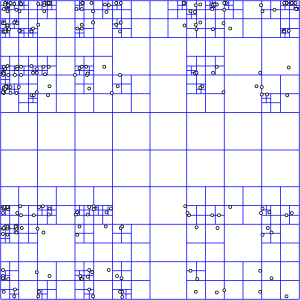
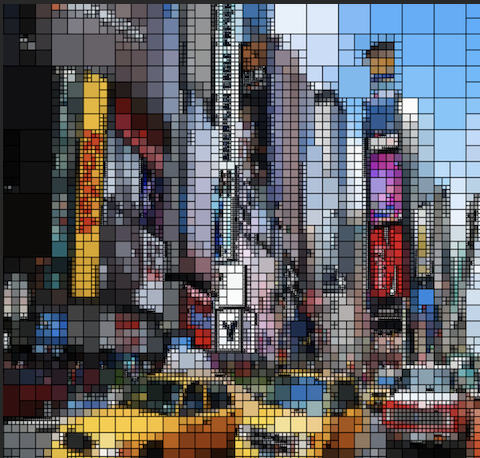

### What to do:
The next 4 code chunks are just API's to setup the quadtree, There are also some functions that viasualize the image segmentation. 

In [38]:
# Open cv library
import cv2

# matplotlib for displaying the images 
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Useful for displaying outputs
def printI(img):
    fig= plt.figure(figsize=(20, 20))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    
    
def printI2(i1, i2):
    fig= plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(cv2.cvtColor(i1, cv2.COLOR_BGR2RGB))
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(cv2.cvtColor(i2, cv2.COLOR_BGR2RGB))

In [39]:
# Beginning of quad-tree implementation
class Node():
    # JRtechs uses implicit pointers by representing the quad-tree as an array. Computationally this is slow and lookup can be 
    # improved to Ω(log4(n)) with a linked implementation however, im unsure how the python backend favors these two cases. both are probably Θ(log4(n)) avg case
    def __init__(self, x0, y0, w, h):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.children = []
    
    def get_width(self):
        return self.width
    
    def get_height(self):
        return self.height
    
    def get_points(self):
        return self.points
    
    def get_points(self, img):
        return img[self.x0:self.x0 + self.get_width(), self.y0:self.y0+self.get_height()]
    
    # Energy method used for determining partitions based on color similarity
    def get_error(self, img):
        pixels = self.get_points(img)
        b_avg = np.mean(pixels[:,:,0])
        b_mse = np.square(np.subtract(pixels[:,:,0], b_avg)).mean()
    
        g_avg = np.mean(pixels[:,:,1])
        g_mse = np.square(np.subtract(pixels[:,:,1], g_avg)).mean()
        
        r_avg = np.mean(pixels[:,:,2])
        r_mse = np.square(np.subtract(pixels[:,:,2], r_avg)).mean()
        
        e = r_mse * 0.2989 + g_mse * 0.5870 + b_mse * 0.1140
        
        return (e * img.shape[0]* img.shape[1])/90000000

In [40]:
# Quadtree implementation
class QTree():
    def __init__(self, stdThreshold, minPixelSize, img):
        self.threshold = stdThreshold                             # Determines the tolerance for color differences
        self.min_size = minPixelSize                              # Minimum segment size
        self.minPixelSize = minPixelSize
        self.img = img                                            # Image instance
        self.root = Node(0, 0, img.shape[0], img.shape[1])        # Root of the qtree
        self.rgb_copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Image copy in rgb for splicing

    def get_points(self):
        return img[self.root.x0:self.root.x0 + self.root.get_width(), self.root.y0:self.root.y0+self.root.get_height()]
    
    def subdivide(self):
        recursive_subdivide(self.root, self.threshold, self.minPixelSize, self.img)
    
    # Display the qtree
    def graph_tree(self):
        fig = plt.figure(figsize=(10, 10))
        plt.title("Quadtree")
        c = find_children(self.root)
        print("Number of segments: %d" %len(c))
        for n in c:
            plt.gcf().gca().add_patch(patches.Rectangle((n.y0, n.x0), n.height, n.width, fill=False))
        plt.gcf().gca().set_xlim(0,img.shape[1])
        plt.gcf().gca().set_ylim(img.shape[0], 0)
        plt.axis('equal')
        plt.show()
        return
    
    # Returns the rbg values for the indices of each segment, an array of 2d arrays
    def readable_children(self):
        c = find_children(self.root)
        segments = []
        
        # Iterate through each node and get the image segment
        # DO NOT use extract_subarray() for this!
        for n in c:
            segment = n.get_points(self.rgb_copy)             
            segments.append(segment)
        return segments
    
    # Used for meta and tracking %Mapped
    def num_children(self):
        return len(find_children(self.root))

    # Left this in from JRtechs but we dont need it. Returns the color grouped image whereby each segment
    # is the mean color of each pixel in the segment. Fun to play around with though
    def render_img(self, thickness = 1, color = (0,0,255)):
        imgc = self.img.copy()
        c = find_children(self.root)
        for n in c:
            pixels = n.get_points(self.img)
            # grb
            gAvg = math.floor(np.mean(pixels[:,:,0]))
            rAvg = math.floor(np.mean(pixels[:,:,1]))
            bAvg = math.floor(np.mean(pixels[:,:,2]))

            # imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 0] = gAvg
            # imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 1] = rAvg
            # imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 2] = bAvg

        if thickness > 0:
            for n in c:
                # Draw a rectangle
                imgc = cv2.rectangle(imgc, (n.y0, n.x0), (n.y0+n.get_height(), n.x0+n.get_width()), color, thickness)
        return imgc

In [41]:
# Function to perform the quadtree partitioning, created 4 children for parent node
def recursive_subdivide(node, k, minPixelSize, img):

    if node.get_error(img)<=k:
        return
    w_1 = int(math.floor(node.width/2))
    w_2 = int(math.ceil(node.width/2))
    h_1 = int(math.floor(node.height/2))
    h_2 = int(math.ceil(node.height/2))


    if w_1 <= minPixelSize or h_1 <= minPixelSize:
        return
    x1 = Node(node.x0, node.y0, w_1, h_1) # top left
    recursive_subdivide(x1, k, minPixelSize, img)

    x2 = Node(node.x0, node.y0+h_1, w_1, h_2) # btm left
    recursive_subdivide(x2, k, minPixelSize, img)

    x3 = Node(node.x0 + w_1, node.y0, w_2, h_1)# top right
    recursive_subdivide(x3, k, minPixelSize, img)

    x4 = Node(node.x0+w_1, node.y0+h_1, w_2, h_2) # btm right
    recursive_subdivide(x4, k, minPixelSize, img)

    node.children = [x1, x2, x3, x4]
    
# Recurse through the qtree
def find_children(node):
    if not node.children:
        return [node]
    else:
        children = []
        for child in node.children:
            children += (find_children(child))
    return children

# Splice a segment from the image. NGL I think np already has a function for this
def extract_subarray(array, start_row, start_col, height, width):
    # Get the number of rows and columns in the original array
    num_rows = len(array)
    num_cols = len(array[0])

    # Ensure the subarray boundaries are within the original array's boundaries
    end_row = min(start_row + height, num_rows)
    end_col = min(start_col + width, num_cols)

    # Extract the subarray using list comprehension
    subarray = [row[start_col:end_col] for row in array[start_row:end_row]]

    return subarray

In [42]:
# More for displaying images
def concat_images(img1, img2, boarder=5, color=(255,255,255)):
    img1_boarder = cv2.copyMakeBorder(
                 img1, 
                 boarder, #top
                 boarder, #btn
                 boarder, #left
                 boarder, #right
                 cv2.BORDER_CONSTANT, 
                 value=color
              )
    img2_boarder = cv2.copyMakeBorder(
                 img2, 
                 boarder, #top
                 boarder, #btn
                 0, #left
                 boarder, #right
                 cv2.BORDER_CONSTANT, 
                 value=color
              )
    return np.concatenate((img1_boarder, img2_boarder), axis=1)

### What to do:
It is important to play around with "threshold" and "minCell" in display_quadtree() in order to find the optimal partition. 60, 40 has worked pretty well for me but its different for every image. I've tried to aim for something which generates < 500 segments just because I don't feel like having millions of images on my computer, and also becasue if minCell is too small the ML won't actually gain anything from the training data and it will lead to an overfit with poor classifications.

Number of segments: 286


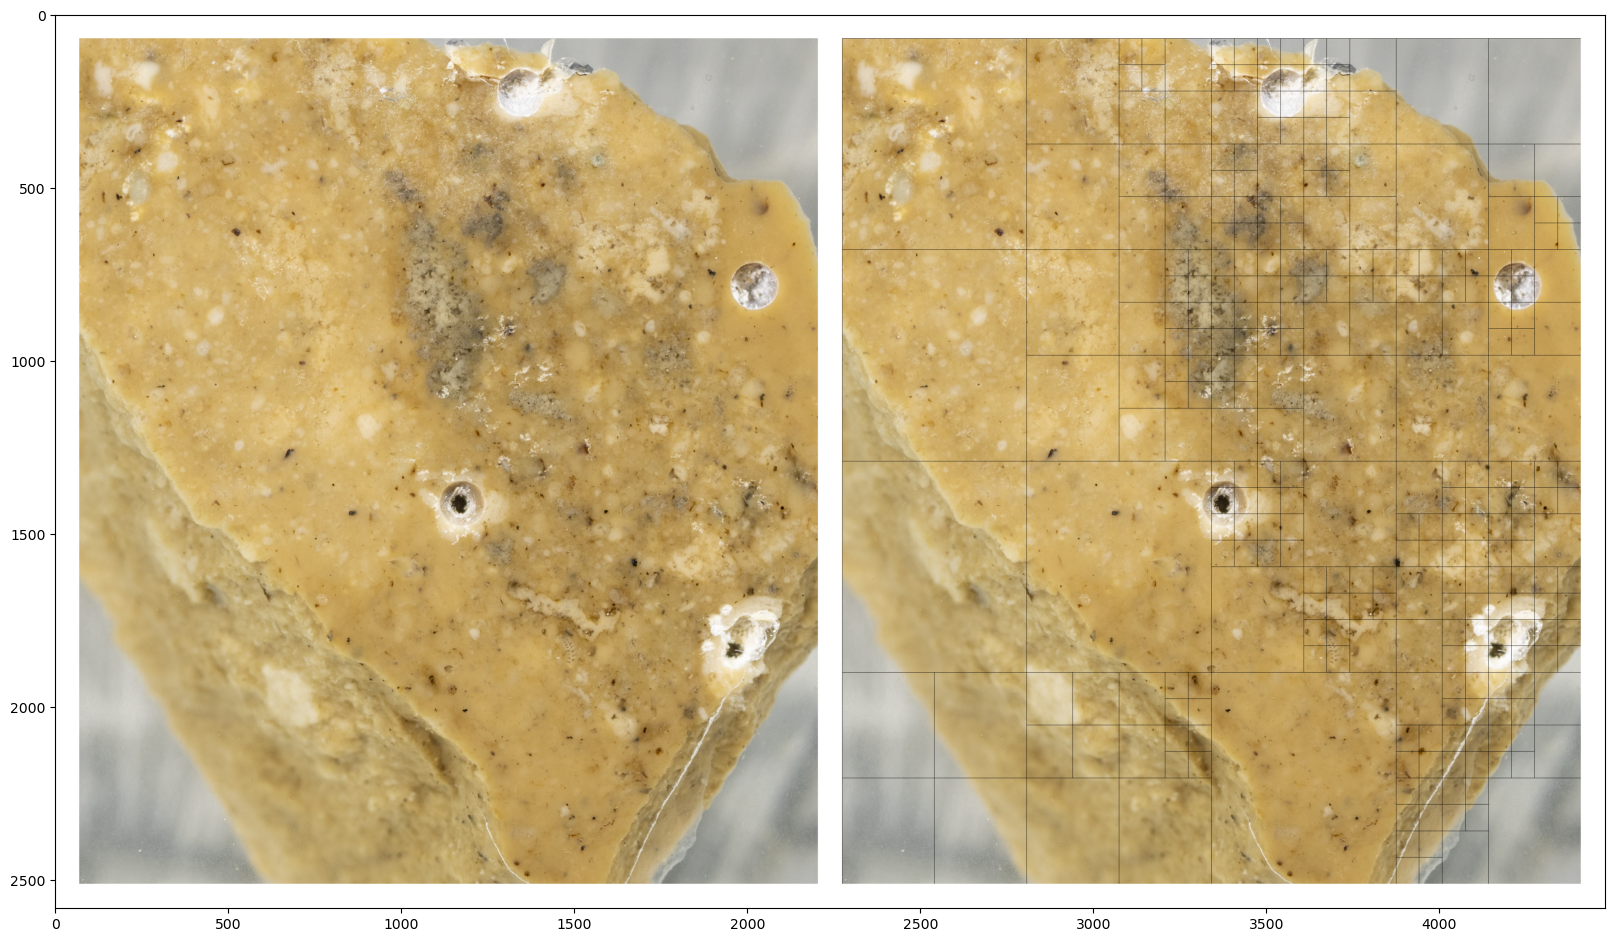

In [52]:
def displayQuadTree(img_name, threshold, minCell, img_boarder, line_boarder, line_color=(0,0,255)):
    imgT= cv2.imread(img_name)
    qt = QTree(threshold, minCell, imgT) 
    qt.subdivide()
    qtImg= qt.render_img(thickness=line_boarder, color=line_color)
    file_name = "output/" + img_name.split("/")[-1]
    # cv2.imwrite(file_name,qtImg)
    file_name_2 = "output/diptych-" + img_name[-6] + img_name[-5] + ".jpg"
    hConcat = concat_images(imgT, qtImg, boarder=img_boarder, color=(255,255,255))
    # cv2.imwrite(file_name_2,hConcat)
    print("Number of segments: %d" %qt.num_children())
    printI(hConcat)

displayQuadTree(random_image, threshold=16, minCell=40, img_boarder=70, line_color=(0,0,0), line_boarder = 1)

# Segment and save images

**Documentation**:
<p>Okay theres a lot to unpack here. Image segmentation works great...mostly. So the alg for recusrive subdivision of the image doesn't include the best checks for corner cases in the event that a node is defined beyond the bounds of the image. This causes extract_subarray() to freak out -- The node exists but is beyond the bounds of the image. So what does it do?, it defines the segment as an empty array. The cv module hates this and, rightly so, complains "ValueError: tile cannot extend outside image."

**My solution** is kind of silly: Just skip over the messed up segments. Typically they are few and ultimately the %compoistion of constituents is claculated as a function of only the existing images so as long as the alg generates images ~+- 5% of the target everything chould be good
    
### What to do:
If everything above ran smoothly, this can be run with no alterations, The inputs ask for quadtree parameters -- these are just whatever you decided on from the cell above. The metadata text files contain the total pixels for each segmented image in order to aid in tracking the %mapped of each sample (Important for tracking point counts on the spreadsheet)

I belive the issue above has been resolved but if it isn't just be wary of how the number of segments in the warning message compare to the number of segments in the above chunk.

In [54]:
# Saving the segments of the quadtree to /Unlabeled
def slice_segments(in_image, imName, external_drive_path):
    image = cv2.imread(random_image)
    image_informal_name = imName[0:7]
    
    meta_data_filename = str(external_drive_path + "/Training_data" + "/" + image_informal_name + "_meta.txt")
    unlabeled_segments_path = str(external_drive_path + "/Training_data/All_data/Unlabeled/")
    
    # Keep some image metadata for later
    if not os.path.exists(meta_data_filename):  
        f = open(meta_data_filename, "x")
        f.write(str(image.shape[0] * image.shape[1]))
        f.close()

    # partition (redundant)
    qtIm = QTree(int(input("Color threshold value: ")), int(input("Minimum Cell Size is: ")), image)
    qtIm.subdivide()

    # Traverse the tree
    segments = qtIm.readable_children()

    print(Fore.RED + "WARNING: " + str(len(segments)) + " image segments " + " will be saved to " + external_drive_path + "/Training_data/All_data" + "/Unlabeled")
    kill_process = input("Type 'quit' to stop or anything else to continue: ")
    if kill_process == 'quit':
        return
    else:
        for segment, i in zip(segments, range(0, len(segments))):  
            # Save the segments to unlabeled
            im = Image.fromarray(np.array(segment))
            name = str(unlabeled_segments_path + imName[0:7] + '_' + str(i) + '.png')
            im.save(unlabeled_segments_path + '/' + imName[0:7] + '_' + str(i) + '.png')
        
slice_segments(random_image, image_name, external_drive_path)

Color threshold value:  16
Minimum Cell Size is:  40


Type 'quit' to stop or anything else to continue:  dont stop


## Tracking classifications (Point counting)

**Documentation:**

It would be nice if we could generate training data and do point counting simultaneuously. To do this, lets just keep a spreadsheet, with column headers as the various constituents and row headers as the image name (we can arrange them by depth later when we know this info, but for now not knowing this is best as it mitigates bias). Each time we complete a captcha for an image segment the percent of each constituent in this spreadsheet will be updated, essentially maintaining a running tally for point counts. It is also a good idea to make a column called 'percent_mapped' -- the percent area of the image mapped so we know for which images point counting is complete. You can imagine if our random capta segmentation only picks imaged from half a sample we will obtain a bias representation of the constituents. This is obviously not the time-optimal way to point count, but its eliminates A LOT of bias that comes with manual mapping of constituents for each image individually.

### What to do:
<p>This step is a little weird because if you want to add images to the /Sample_Images directory, you cant re-run this because it will delete all of your previously saved point counts -- **It Won't do this** to be clear -- but it wont add the new images. Running this once should be enough. if you want to add new images you have to manually go into the spreadsheet and add new rows.

### Make and Format a Spreadsheet

In [60]:
def grab_all_image_names(folder_path):
    # List all files in the specified directory
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Check if the directory is empty
    if not files:
        return None
    
    # Return all image names
    image_names = []
    for file in files:
        image_names.append(file[0:7])
    
    return image_names


spreadsheet_directory = home
images_directory = spreadsheet_directory + '/Sample_Images'

row_names = grab_all_image_names(images_directory)
col_names_const = ['Ooids', 'Micrite-Cement', 'Bioclasts', 'Unknown', 'Total_mapped_area', '%Mapped', 'Alteration']
col_names_sat = ['Organic Dominated', 'Pore Space', 'Cementation', 'Neomorphisms/Restructuring', ' ', ' ', ' ']

# Create a workbook and add a worksheet. Don't replace if a spreadsheet already exists!
spreadsheet_path = spreadsheet_directory + '/Point_Counts.xlsx'
if (not os.path.exists(spreadsheet_path)):
    workbook = xlsxwriter.Workbook(spreadsheet_path)
    worksheet = workbook.add_worksheet()
    worksheet2 = workbook.add_worksheet()
    
    row = 0
    col = 1
    # Iterate over the data and write it out row by row.
    # Yea this is such a waste of codespace but it works, sue me
    for sample_name in row_names:
        # Filter out ds.store meta
        if 'DS' not in sample_name:
            worksheet.write(row, 0, sample_name)
            worksheet2.write(row, 0, sample_name)
        row += 1
    for constituent, binary in zip(col_names_const, col_names_sat):
        worksheet.write(0, col, constituent)
        worksheet2.write(0, col, binary)
        col += 1
    for i in range(len(row_names)):
        for j in range(len(col_names_const)):
            r, c = i+1, j+1
            worksheet.write(r, c, 0)
    
    for i in range(len(row_names)):
        for j in range(len(col_names_sat)):
            if col_names_sat[j] == ' ':
                continue
            r, c = i+1, j+1
            worksheet2.write(r, c, 0)
    
    
    workbook.close()

# Captcha GUI
## Its a lot of code but only becasue front end is annoying like that

**Documentation:**

### What to do:
This code should be self contained. If you Run all of the above steps, you should be able to run this over and over again without issue

**Documented Errors:**

    'TclError: image "pyimage{n}" doesn't exist' -- Arises from the code not saving a copy of a displayed image, causing garbage collection to get rid of the image before it can be used. Becasue the program displays 100s of images I didnt want to save every one. An easy fix is to just run root.mainloop() and close out of any existing tabs that appear


## Some Functions for Excel Manipulation
Updating The Constituents:

$$
  \frac{(P_{curr} * T_{curr}) + SegmentArea}{(T_{curr} + SegmentArea)}, \quad \frac{(P_{curr} * T_{curr})}{(T_{curr} + SegmentArea)} \quad \forall \quad \text{Non-selected Constituents}
$$

Updating The Alteration Score

$$
  \frac{(P_{curr} * T_{curr}) + (Rating * SegmentArea)}{(T_{curr} + SegmentArea)}
$$

Updating Alteration Features Columns: No averaging because multiple features is possible

$$
  \frac{(P_{curr} * T_{curr}) + SegmentArea}{(T_{curr} + SegmentArea)}
$$

In [61]:
# Methods for spreadsheet manipulation

def locate_sample(spreadsheet_path, name_query, sheet_num):
    workbook = openpyxl.load_workbook(spreadsheet_path)
    sheet = workbook[workbook.sheetnames[sheet_num]]
    # Only search the first row becasue the sample name cant be anywhere else
    for row in sheet.iter_rows():
        for cell in row:
            if str(cell.value) == name_query:
                return cell.row, cell.column
            
    raise Exception(f"Query for {name_query} at location {spreadsheet_path} returned Null")
    return
        
def get_cell(row, col, spreadsheet_path, sheet_num):
    workbook = openpyxl.load_workbook(spreadsheet_path)
    sheet = workbook[workbook.sheetnames[sheet_num]]
    
    val = sheet.cell(row=row, column=col).value
    workbook.save(spreadsheet_path)
    return val

def change_cell(row, col, spreadsheet_path, val, sheet_num):
    workbook = openpyxl.load_workbook(spreadsheet_path)
    sheet = workbook[workbook.sheetnames[sheet_num]]
    
    sheet.cell(row=row, column=col, value=val)
    workbook.save(spreadsheet_path)
    return val

def update_percent(Pcurr, Tcurr, segment_area, rating, isSubject):
    # Div by 0 error should not occur because total area is always updated 
    # Update the rating
    if rating is not None:
        return ((Pcurr * Tcurr) + (rating * segment_area)) / (Tcurr + segment_area)
    # Update the constituent or feature
    elif isSubject == True:
        return ((Pcurr * Tcurr) + (segment_area)) / (Tcurr + segment_area)
    # Update other constituents whose areas are not to be updated
    else:
        return (Pcurr * Tcurr) / (Tcurr + segment_area)
    

## Main Window and Functionality

In [71]:
import cv2
import os
from PIL import Image, ImageTk
import tkinter as tk
import shutil
from tkinter import Tk, ttk, Button, Label
from tkinter import filedialog
import random
import openpyxl

############## Image Manipulation #################
def find_and_outline_segment(large_image_path, small_image_path, outline_width):
    # Load images
    large_image = cv2.imread(large_image_path)
    small_image = cv2.imread(small_image_path)

    # Convert images to grayscale
    large_image_gray = cv2.cvtColor(large_image, cv2.COLOR_BGR2GRAY)
    small_image_gray = cv2.cvtColor(small_image, cv2.COLOR_BGR2GRAY)

    # Template matching
    result = cv2.matchTemplate(large_image_gray, small_image_gray, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Get the coordinates of the matched region
    top_left = max_loc
    h, w = small_image_gray.shape
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # Draw black outline around the matched region
    cv2.rectangle(large_image, top_left, bottom_right, (0, 0, 0), thickness=outline_width)

    return large_image, small_image

def display_images():
    global image_paths, recent, label_large, label_small, directory, large_image_area
    
    # Choose a random image from the unlabeled directory
    if len(image_paths) == 0:
        root.destroy()
        print(Fore.GREEN + f"All images in {directory} have been classified!")
        return
        
    random_image = random.choice(image_paths)
    recent = random_image
    
    # Must redefine large image
    large_image = str(home + "/Sample_Images/" + random_image[random_image.index('Img'):random_image.index('Img') + 7] + ".tif")
    large_image_area = cv2.imread(large_image).shape[0] * cv2.imread(large_image).shape[1]
    
    # Find and outline the segment in the large image
    outlined_large_image, small_image = find_and_outline_segment(large_image, random_image, outline_width=5)
    
    # Convert images from BGR to RGB (for displaying with PIL)
    large_image_rgb = cv2.cvtColor(outlined_large_image, cv2.COLOR_BGR2RGB)
    small_image_rgb = cv2.cvtColor(small_image, cv2.COLOR_BGR2RGB)

    # Convert images to PIL format
    large_image_pil = Image.fromarray(large_image_rgb)
    small_image_pil = Image.fromarray(small_image_rgb)
    
    # Shrink the larger image to fit in the window
    large_image_pil = large_image_pil.resize((400, 400), Image.ANTIALIAS)
    
    # Convert PIL images to ImageTk format
    large_image_tk = ImageTk.PhotoImage(large_image_pil)
    small_image_tk = ImageTk.PhotoImage(small_image_pil)

    images_frame = tk.Frame(root)
    images_frame.pack(side = tk.BOTTOM)
    
    # If the labels dont exist, make a new ones, if they do reconfigure them
    if label_large is None:
        label_large = tk.Label(images_frame, image=large_image_tk)
        label_large.image = large_image_tk
        label_large.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)


        label_small = tk.Label(images_frame, image=small_image_tk)
        label_small.image = small_image_tk
        label_small.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
    else:
        label_large.config(image=large_image_tk)
        label_large.image = large_image_tk  # Keep a reference to avoid garbage collection
        
        label_small.config(image=small_image_tk)
        label_small.image = small_image_tk  # Keep a reference to avoid garbage collection
        
    
############ Buttons and app functionality ######################
def update_spreadsheet(features, alteration_score, constituent):
    global recent, spreadsheet_path, large_image_area
    
    # 1. Get the segment area
    cvImga = cv2.imread(recent)
    area = cvImga.shape[0] * cvImga.shape[1]
    
    
    # 2. Get the image name for spreadsheet navigtion
    name_query = recent[recent.index('Img'):recent.index('Img') + 7]
    
    # 2.1. Query for the correct row of the sample
    sample_row = locate_sample(spreadsheet_path, name_query, sheet_num = 0)[0]
    
    # 2.2. Save a copy of the total area
    total_area_col = locate_sample(spreadsheet_path, 'Total_mapped_area', sheet_num = 0)[1]
    current_total_area = get_cell(sample_row, total_area_col, spreadsheet_path, sheet_num = 0)
    
    # Change the total area and update percent mapped
    change_cell(sample_row, total_area_col, spreadsheet_path, current_total_area + area, sheet_num = 0)
    percent_mapped = (current_total_area + area)/large_image_area
    change_cell(sample_row, locate_sample(spreadsheet_path, '%Mapped', sheet_num = 0)[1], spreadsheet_path, percent_mapped, sheet_num = 0)
    
    # 3. Update the Constituent percentage distrib
    for classif in classifications_order:
        rating = None
        isSubject = False
        # Dont want to update this col!
        if classif == 'Total_mapped_area':
            continue
        # Update params
        if classif == constituent:
            isSubject = True
        r, c = sample_row, locate_sample(spreadsheet_path, classif, sheet_num = 0)[1]
        old_value = get_cell(r, c, spreadsheet_path, sheet_num = 0)
        new_value = update_percent(old_value, current_total_area, area, rating, isSubject)
        change_cell(r, c, spreadsheet_path, new_value, sheet_num = 0)
    
    # 5. Update the Alteration Score
    r, c = sample_row, locate_sample(spreadsheet_path, 'Alteration', sheet_num = 0)[1]
    old_value = get_cell(r, c, spreadsheet_path, sheet_num = 0)
    new_value = update_percent(old_value, current_total_area, area, rating = alteration_score, isSubject = False)
    change_cell(r, c, spreadsheet_path, new_value, sheet_num = 0)
    
    # Update the features percents: The features are technically already the incices of the cols :)
    for feature in features:
        r, c = sample_row, locate_sample(spreadsheet_path, feature, sheet_num = 1)[1]
        old_value = get_cell(r, c, spreadsheet_path, sheet_num = 1)
        change_cell(r, c, spreadsheet_path, update_percent(old_value, current_total_area, area, rating = None, isSubject = True), sheet_num = 1)
    
def classify():
    global image_paths, image, recent, classif
    
    # Move the file to the respective classification
    source_path = recent
    destination_path = external_drive_path + '/Training_data/All_data/' + classif
    shutil.move(source_path, destination_path)

# Function to select a directory
def select_directory():
    global image_paths, large_image, label_large, label_small, directory
    
    directory = filedialog.askdirectory()
    if directory:
        image_paths = [os.path.join(directory, f) for f in os.listdir(directory)
                       if os.path.isfile(os.path.join(directory, f)) and
                       f.lower().endswith((".png", ".jpg", ".jpeg"))]
        label_large = None
        label_small = None
        display_images()

# Global variable to store the rating
def update_classif(value):
    global classif
    classif = value
    
def update_rating(value):
    global rating
    rating = value

def submit_action():
    global rating, classif
    # Corner case if form is uncomplete
    if rating == None or classif == None:
        return
    if classif == 'None':
        display_images()
        classif, rating = None, None
        return
    # Get features from the checkboxes
    checked_boxes = [checkboxes[i] for i, var in enumerate(checkbox_vars) if var.get() == 1]
    # Procedural updates
    update_spreadsheet(checked_boxes, rating, classif)
    classify()
    image_paths.remove(recent)
    display_images()
    # Reset these so incomplete forms aren't submitted
    classif, rating = None, None
    

# Initialize variables
directory = None
image_paths = []          # Keep track of the classified images
large_image = None        # The image from which segment is pulled
large_image_area = None   # It avoids like 1 call to cv but it more efficient
image = None              # Image segment -- Actually I'm pretty sure this var is only utilized once.
recent = None             # Keep a reference to the image segment
label_large = None        # Used for formatting
label_small = None        # Used for formatting images
classif = None            # The selected constituent
rating = None             # The selected alteration score

# Just ensuring that we have this from outer scope. You can also specify the path explicitly as such:
spreadsheet_path = "/Users/coltenrodriguez/Desktop/ResolutionGuyotProj/Point_Counts.xlsx"
# spreadsheet_path = spreadsheet_path

# Create the main window
root = tk.Tk()
root.title("Facies Classification Captcha")

# Create all the buttons and frames to make everything pretty
text_frame = tk.Frame(root)
text_frame.pack(side = tk.TOP, padx=10, pady=10)
T = tk.Label(text_frame, text="Facies Classification", height=2, width=30).pack(side=tk.LEFT)
T2 = tk.Label(text_frame, text="Features", height=2, width=30).pack(side=tk.LEFT)
T3 = tk.Label(text_frame, text="Alteration Score", height=2, width=30).pack(side=tk.LEFT)

buttons_frame = tk.Frame(root)
buttons_frame.pack(side = tk.TOP, padx=10, pady=10)

frame_classificationbuttons = tk.Frame(buttons_frame)
frame_classificationbuttons.pack(side = tk.LEFT, padx=10, pady=10)

frame_checkbuttons = tk.Frame(buttons_frame)
frame_checkbuttons.pack(side=tk.LEFT, padx=10, pady=10)

# Lmao okay this is a terrible variable name, these are the buttons for alteration scoring
frame_buttons = tk.Frame(buttons_frame)
frame_buttons.pack(side=tk.LEFT, padx=10, pady=10)

# Two copies of this, one is used for spreadsheet references
classifications_order = ['Ooids', 'Micrite-Cement', 'Bioclasts', 'Unknown',	'Total_mapped_area']
classifications = ['Bioclasts', 'Micrite-Cement', 'Ooids', 'None', 'Unknown']
for i in range(1, 6):
    button = tk.Button(frame_classificationbuttons, text=f"{classifications[i-1]}", command=lambda value=classifications[i-1]: update_classif(value), width = 25)
    button.pack(fill = 'both', pady=2)

checkboxes = ['Organic Dominated', 'Pore Space', 'Cementation', 'Neomorphisms/Restructuring']
checkbox_vars = []
for i in range(1, 5):
    var = tk.IntVar()
    checkbox = ttk.Checkbutton(frame_checkbuttons, text=f"{checkboxes[i - 1]}", variable=var)
    checkbox.pack(anchor='w', pady=2)
    checkbox_vars.append(var)

alterations = ['Unaltered', 'Some Alteration (1-30%)', 'Patchy or Moderate Alteration (30-60%)', 'Patchy Nonalteration (60-80%)', 'Completely Altered']
# Add 4 regular buttons to the right
for i in range(1, 6):
    button = tk.Button(frame_buttons, text=f"{alterations[i - 1]}", command=lambda value=i: update_rating(value), width = 25)
    button.pack(anchor='e', pady=2)
    
# Button to select directory
button_select = Button(root, text="Select Directory", command=select_directory)
button_select.pack(pady=10, side=tk.BOTTOM)

# Add the submit button at the bottom
submit_button = tk.Button(root, text="Submit", command=submit_action)
submit_button.pack(side=tk.TOP, pady=1)

root.mainloop()

/var/folders/vv/wqjks1114hz5w6vtzybkd8gc0000gn/T/ipykernel_61644/2750762906.py:63: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  large_image_pil = large_image_pil.resize((400, 400), Image.ANTIALIAS)


In [64]:
root.mainloop()